# DIY Monte Carlo!!!

Here you will setup and run a monte carlo analysis from scratch - no more shift+enter!!!


The workflow here is almost identical to the ``freyberg_k_r_mc activity`` - its not cheating to use that activity for guidance

In [1]:
%matplotlib inline
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyemu
import platform
if 'window' in platform.platform().lower():
    newln='\n'
    ppp = 'pest++ '
else:
    newln='\r\n'
    ppp = './pestpp '

setting random seed


In [2]:
base_dir = os.path.join("..","..","models","Freyberg","Freyberg_zones")
assert os.path.exists(base_dir)
[shutil.copy2(os.path.join(base_dir,f),f) for f in os.listdir(base_dir)];

In [53]:
#step 0 - create a pyemu Monte Carlo object
sc = pyemu.Schur("freyberg_zones.jcb")
mc = pyemu.MonteCarlo(pst="freyberg_zones.pst")

In [63]:
#step 1 - make draws with the Monte Carlo object
mc.draw(1000,cov=sc.posterior_parameter,par_file="freyberg_zones.bpa")

/Users/jwhite/Dev/python/pyemu/pyemu/en.py:538: UserWarning: deprecation warning: enforce_bounds should be either 'reset' or 'drop', not bool.  resetting to 'reset'.
  " to 'reset'.")


<module 'numpy' from '/Users/jwhite/anaconda/lib/python3.5/site-packages/numpy/__init__.py'>


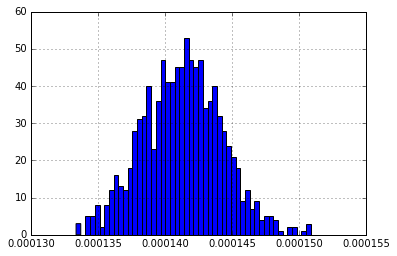

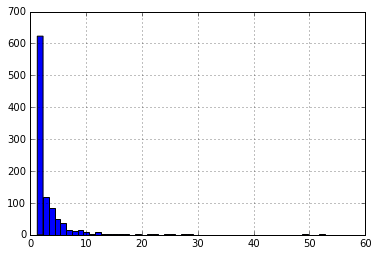

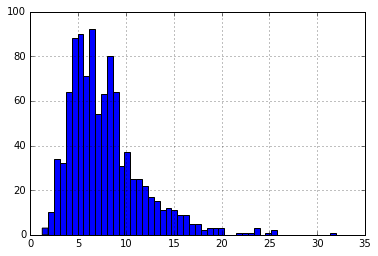

In [64]:
#step 2 - visualize a few parameter histograms via the parensemble attribute
print(np)
for par in mc.pst.adj_par_names[:3]:
    fig = plt.figure()
    ax = plt.subplot(111)
    mc.parensemble.loc[:,par].hist(ax=ax,bins=50)
plt.show()

In [65]:
# step 3 - save the parensemble to "sweep_in.csv"
mc.parensemble.to_csv("sweep_in.csv")

In [66]:
# step 4 - call the pyemu slave helper to run the ensemble via sweep - 
# please just copy this from freyebrg_k_r_mc notebook and change the name of the pst file
pyemu.helpers.start_slaves(base_dir,"sweep","freyberg_zones.pst",num_slaves=20,master_dir='.')

In [67]:
# step 5 - import the model outputs from the sweep (sweep_out.csv)
# and drop any failed runs
df = pd.read_csv("sweep_out.csv")
df = df.loc[df.failed_flag==0,:] 

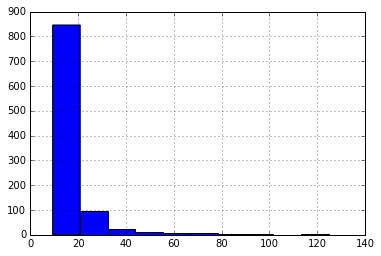

In [68]:
# step 6 - plot phi, filter based on "acceptable" phi
df.loc[:,"phi"].hist()

In [70]:
# step 7 - plot filtered and unfiltered forecast historgrams
acceptable_phi = 12.0
good_enough = df.loc[df.phi<acceptable_phi].index.values
print(good_enough)

[  1   5   6  11  12  13  31  32  33  36  37  44  45  51  52  54  57  61
  69  75  76  80  86  87  96 101 102 104 109 114 115 119 140 146 149 154
 155 157 158 159 164 170 171 175 179 183 185 187 188 193 197 202 204 212
 214 225 226 229 230 237 244 249 251 257 258 261 266 268 269 275 283 286
 287 290 294 297 300 305 308 310 314 330 337 340 342 343 353 357 359 365
 367 373 374 378 381 382 384 385 386 388 392 393 398 409 410 411 416 432
 434 449 453 456 460 463 471 474 478 487 491 493 516 520 524 528 529 534
 549 554 560 562 569 572 576 583 588 591 593 595 596 597 600 603 609 612
 625 626 638 644 646 647 648 653 660 664 665 674 675 676 678 679 681 687
 696 697 701 703 708 714 715 720 721 728 731 732 734 735 736 749 762 763
 764 765 781 783 792 794 796 797 798 799 804 813 814 815 820 822 825 833
 838 840 852 862 865 868 869 873 878 880 883 884 890 891 897 906 907 908
 910 913 922 923 924 939 942 943 946 949 953 960 962 964 967 968 973 974
 977 983 987 988]


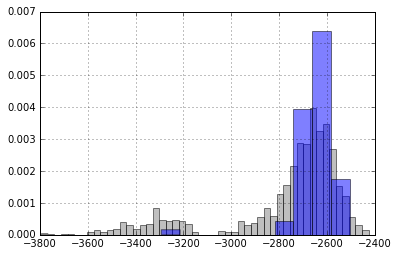

In [71]:
fig = plt.figure()
ax = plt.subplot(111)
df.loc[:,"RIVFLUX_FORE"].hist(ax=ax,alpha=0.5,color="0.5",normed=True,bins=50)
df.loc[good_enough,"RIVFLUX_FORE"].hist(ax=ax,alpha=0.5,color='b',normed=True)
plt.show()

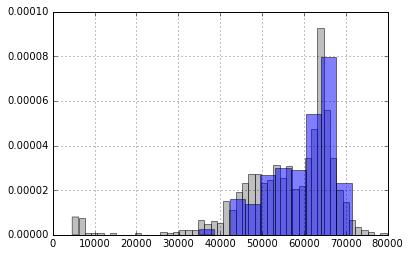

In [72]:
fig = plt.figure()
ax = plt.subplot(111)
df.loc[:,"TRAVEL_TIME"].hist(ax=ax,alpha=0.5,color="0.5",normed=True,bins=50)
df.loc[good_enough,"TRAVEL_TIME"].hist(ax=ax,alpha=0.5,color='b',normed=True)
plt.show()

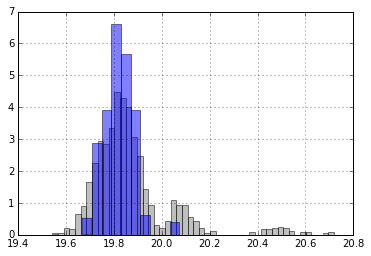

In [73]:
fig = plt.figure()
ax = plt.subplot(111)
df.loc[:,"FR03C16"].hist(ax=ax,alpha=0.5,color="0.5",normed=True,bins=50)
df.loc[good_enough,"FR03C16"].hist(ax=ax,alpha=0.5,color='b',normed=True)
plt.show()

In [74]:
mc.pst.pestpp_options["forecasts"]

'rivflux_fore,travel_time,fr03c16,fr04c9'

In [75]:
df_foreu = pd.read_csv(os.path.join("..","freyberg_zones","freyberg_zones.pred.usum.csv"),index_col=0)
df_foreu

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound
name,,,,,,,,
FR03C16,19.6124,0.473822,18.6648,20.5601,19.8242,0.086394,19.6514,19.9970
FR04C9,22.3109,3.319190,15.6725,28.9493,23.3901,0.553070,22.2840,24.4963
RIVFLUX_FORE,-2811.0500,576.997000,-3965.0500,-1657.0600,-2639.9700,57.014200,-2754.0000,-2525.9400
TRAVEL_TIME,16856.9000,51189.100000,-85521.3000,119235.0000,60927.5000,14944.100000,31039.2000,90815.8000


In [76]:
data = []
for fore in df_foreu.index:
    pr_mc = df.loc[:,fore].std()
    pr_fosm = df_foreu.loc[fore,"prior_stdev"]
    pt_mc = df.loc[good_enough,fore].std()
    pt_fosm = df_foreu.loc[fore,"post_stdev"]
    data.append([pr_mc,pr_fosm,pt_mc,pt_fosm])
    print(fore,pr_mc,pr_fosm,pt_mc,pt_fosm)
df_data = pd.DataFrame(data=data,index=df_foreu.index,columns=["pr_mc","pr_fosm","pt_mc","pt_fosm"])

FR03C16 0.1688071360712755 0.473822 0.06232866560912833 0.0863945
FR04C9 0.7258535391394239 3.31919 0.3662272133774407 0.55307
RIVFLUX_FORE 259.0058475800715 576.997 89.03979485790036 57.0142
TRAVEL_TIME 12343.253889214508 51189.1 7449.514913293568 14944.1


In [77]:
df_data

,pr_mc,pr_fosm,pt_mc,pt_fosm
name,,,,
FR03C16,0.168807,0.473822,0.062329,0.086394
FR04C9,0.725854,3.319190,0.366227,0.553070
RIVFLUX_FORE,259.005848,576.997000,89.039795,57.014200
TRAVEL_TIME,12343.253889,51189.100000,7449.514913,14944.100000
